# Define and use your own Mass-Balance Model

In this notebook we define a Mass-Balance model, open the glacier geometry at the RGI date (represented by the flowlines) and put these two parts together to conduct a dynamic glacier model run.

We start with the already well-known initialisation of our glacier of choice:

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from oggm import cfg, utils, workflow, tasks
from oggm.cfg import SEC_IN_YEAR

cfg.initialize(logging_level='WARNING')

# Local working directory (where OGGM will write its output)
WORKING_DIR = utils.gettempdir('OGGM_model_from_scratch')
cfg.PATHS['working_dir'] = WORKING_DIR

rgi_ids = ['RGI60-11.00897']

cfg.PARAMS['border'] = 80
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5'
gdirs = workflow.init_glacier_directories(rgi_ids, from_prepro_level=3, prepro_base_url=base_url)
gdir = gdirs[0]

2023-03-14 22:24:30: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-03-14 22:24:30: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-03-14 22:24:30: oggm.cfg: Multiprocessing: using all available processors (N=8)
2023-03-14 22:24:31: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2023-03-14 22:24:31: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


## Define your own Mass-Balance Model

Here is an example of how you can provide your own Mass-Balance Model to OGGM.

This is done using Object-Oriented Programming, which means our newly created class `RandomLinearMassBalance` can build upon the existing OGGM class `MassBalanceModel`. By doing so we can make sure that our new Mass-Balance Model has the principle structure that OGGM expects a Mass-Balance Model to look like.

Now we can define the behaviour of our Mass-Balance Model as we wish. At a minimum, we need to define `get_annual_mb()`, which should return the mass-balance value for given heights and at a given year.

So let's have a look at what the code could look like:

In [33]:
# here we import the base class for all MassBalanceModels inside of OGGM
from oggm.core.massbalance import MassBalanceModel

# now we define that our new class RandomLinearMassBalance 
# should build upon OGGMs MassBalanceModel
class RandomLinearMassBalance(MassBalanceModel):
    """Mass-balance as a linear function of altitude with random ELA.
    
    The reference ELA is taken as the 40% percentile altitude of the glacier.
    It then varies randomly from year to year.
    This class implements the MassBalanceModel interface so that the
    dynamical model can use it. Even if you are not familiar with object
    oriented programming, I hope that the example below is simple enough.
    """

    # here we can define changeable parameters of our model, and also
    # define default values for them
    def __init__(self, gdir, ela_h, grad=3., sigma_ela=200., seed=None):
        """ Initialize.
        Parameters
        ----------
        gdir : oggm.GlacierDirectory
            the working glacier directory
        ela_h : float
            the average ELA
        grad: float
            Mass-balance gradient (unit: [mm w.e. yr-1 m-1])
        sigma_ela: float
            The standard deviation of the ELA (unit: [m])
        seed : int, optional
            Random seed used to initialize the pseudo-random number generator.
        Attributes
        ----------
        temp_bias : float, default 0
            A "temperature bias" doesn't makes much sense in the linear MB
            context, but we implemented a simple empirical rule:
            + 1K -> ELA + 150 m
        """
        super(RandomLinearMassBalance, self).__init__()
        self.valid_bounds = [-1e4, 2e4]  # in m
        self.grad = grad
        self.orig_ela_h = ela_h
        self.sigma_ela = sigma_ela
        self.hemisphere = 'nh'
        self.rng = np.random.RandomState(seed)
        self.ela_h_per_year = dict()  # empty dictionary

    # this is a unique attribute of our MassBalance model we are currently
    # defining
    def get_random_ela_h(self, year):
        """This generates a random ELA for the requested year.
        Since we do not know which years are going to be asked for we generate
        them on the go.
        """

        year = int(year)
        if year in self.ela_h_per_year:
            # Nothing to be done
            return self.ela_h_per_year[year]

        # Else we generate it for this year
        ela_h = self.orig_ela_h + self.rng.randn() * self.sigma_ela
        self.ela_h_per_year[year] = ela_h
        return ela_h

    # here we redefine an attribute all MassBalance model must provide,
    # as this is used for the communication during a dynamic run
    def get_annual_mb(self, heights, year=None, fl_id=None, fls=None):

        # Compute the mass-balance gradient
        ela_h = self.get_random_ela_h(year)
        mb = (np.asarray(heights) - ela_h) * self.grad

        # Convert to units of [m s-1] (meters of ice per second)
        return mb / SEC_IN_YEAR / cfg.PARAMS['ice_density']

Now that we have defined our MassBalanceModel class we can define a instance of it:

In [34]:
mb_model = RandomLinearMassBalance(gdir, 3000)

And explore some properties of our new Mass-Balance model:

In [35]:
mb_model.grad

3.0

In [36]:
mb_model.sigma_ela

200.0

Where are this values defined? Can you define a Mass Balance model with different values?

<div class="alert alert-success">
<details><summary><i>Click for the answer</i></summary>
<code>mb_model = RandomLinearMassBalance(gdir, grad=4, sigma_ela=150)
</code>
</div>

We also can ask for the Mass Balance profile for a specific year:

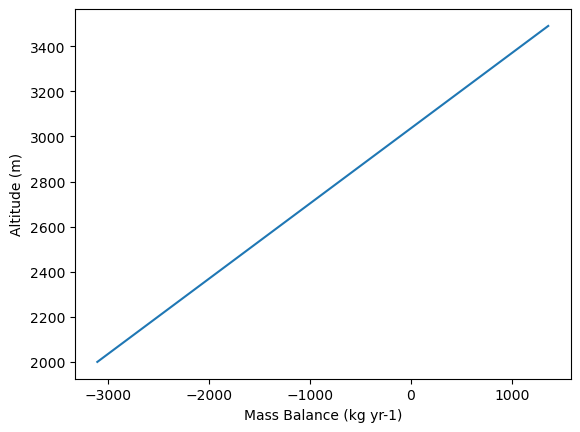

In [37]:
# first define the height range you are interested in
heights = np.arange(2000, 3500, 10)

# get the Mass Balance values for this heights for a specific year and plot them
mb_2000 = mb_model.get_annual_mb(heights, year=2000)
# OGGM internally works with SI units which are meters of ice per second,
# for interpretation we need to convert them into kg per year
mb_2000 = mb_2000 * SEC_IN_YEAR * cfg.PARAMS['ice_density']

# and finally we can plot it
plt.plot(mb_2000, heights)
plt.ylabel('Altitude (m)')
plt.xlabel('Mass Balance (kg yr-1)');

In [38]:
# or also can access other usful information which is available through the base class MassBalanceModel
mb_model.get_ela(year=2000)

3036.6023486542617

## Dynamic model run with user provided Mass Balance Model

Now we connect our defined mass balance model with the geometry through the dynamic model.

The connection of individual parts is straightforward because we agreed on a way of communication by building our Mass-Balance Model upon the base class of OGGM.

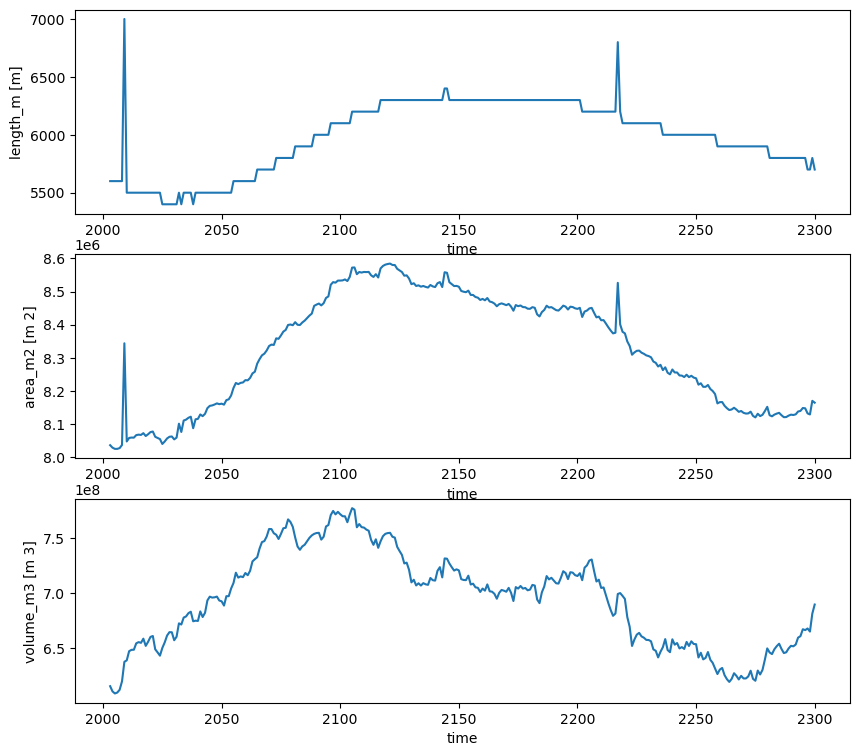

In [39]:
# First we open our glacier geometry, which is already converted
# into the flowline representation 
fls = gdir.read_pickle('model_flowlines')

# We also need to define the year of our geomtery
y0 = gdir.rgi_date

# Then we import the dynamic solver we want to use
from oggm.core.flowline import SemiImplicitModel

# And bring the individual parts together
model = SemiImplicitModel(flowlines=fls, mb_model=mb_model, y0=y0)

# This model we now can use to conduct a dynamic glacier model run,
# here for example until 2100
ds = model.run_until_and_store(2300)

# And finally we can plot the results
f, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(10, 9))
ds.length_m.plot(ax=ax1)
ds.area_m2.plot(ax=ax2)
ds.volume_m3.plot(ax=ax3);